In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from mnist_downsample import Downsample, visualize_sample
from torchvision import datasets, transforms
from model import FPGAnet

# Generating the Dataset

The code for the dataset generation is described in the `mnist_downsample.py`.

* The MNIST-10 dataset is downsampled to **5x5 pixels 1-bit image** to simulate possible inputs in the 5x5 button matrix.
* As the MNIST-10 dataset was not meant to be downscaled to 5x5, the new dataset may look rather hard to read.
* It is important to note that the average input from the user has a very high chance of getting classified correctly.

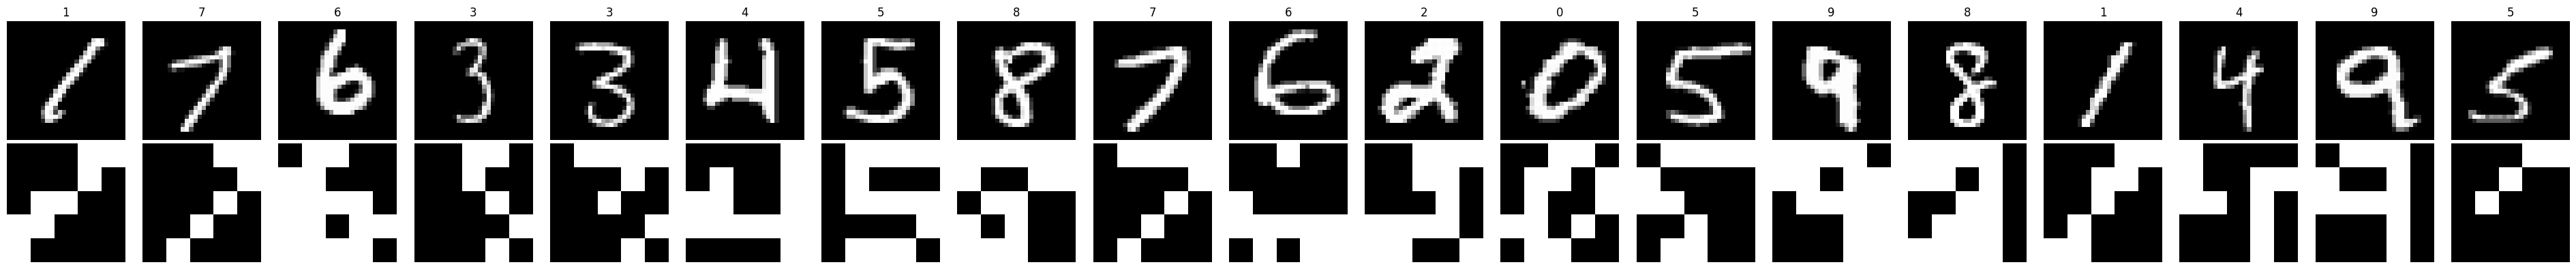

In [ ]:
# Load the MNIST dataset
mnist_original = datasets.MNIST(
    root=".",
    train=True,
    download=True,
    transform=transforms.ToTensor()
)

# Load the MNIST dataset and apply the downsampling
mnist_processed = datasets.MNIST(
    root=".",
    train=True,
    download=False,
    transform=transforms.Compose([
        transforms.ToTensor(),
        Downsample(threshold=0.5, out_size=5),
    ])
)

# Load the testing MNIST dataset and apply the downsampling
mnist_test_processed = datasets.MNIST(
    root=".",
    train=False,
    download=True,
    transform=transforms.Compose([
        transforms.ToTensor(),
        Downsample(out_size=5),
    ])
)

# Compare the original and the downsampled datasets
visualize_sample(mnist_original, mnist_processed, num_samples=19)

# Model Training

* The training of the model takes around **8 minutes on GPU**. 
* The final accuracy after 20 epochs is **roughly 87%**.
* As mentioned earlier, some of the entries of the downsampled dataset are hard to classify even for humans and the average input from the user the NN will be seeing should be easily classifiable.

In [ ]:
# Use GPU if available, otherwise use CPU
device = "cuda" if torch.cuda.is_available() else "cpu"
if device == "cuda": 
    print("Using GPU") 
else:
    print("Using CPU")
    
# Instantiate the model
model = FPGAnet().to(device)

# Define the loss function and the optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

# Define the hyperparameters
batch_size = 128
num_epochs = 20

# Create the training batches from the downsampled training dataset
train_loader = DataLoader(
    mnist_processed,
    batch_size=batch_size,
    shuffle=True,
    drop_last=True
    # If the last batch is smaller than the batch size, we drop it
)

# Create the testing batches from the downsampled testing dataset
test_loader = DataLoader(
    mnist_test_processed,
    batch_size=batch_size,
    shuffle=False
)

weights_path = "fpganet2.pth"
model.load_state_dict(torch.load(weights_path, map_location=device))


# # The main training loop
# # An epoch is one pass through the entire training dataset
# for epoch in range(num_epochs):
#     # We put the model in training mode
#     model.train()
#     train_loss = 0

#     # We iterate through all the batches (x are the images of a batch and y are the labels)
#     for x, y in train_loader:
#         x, y = x.to(device), y.to(device)

#         # We reset the gradient
#         optimizer.zero_grad()
#         # We predict the labels by doing a forward pass (it's a vector)
#         out = model(x)
#         # We comput the batch loss by comparing the predicted labels with the true labels
#         loss = criterion(out, y)
#         # We backpropagate the loss and update the weights
#         loss.backward()
#         # We take an optimization step to update the weights
#         optimizer.step()

#         # We accumulate the loss for all batches
#         train_loss += loss.item()

#     # We get the average batch loss
#     train_loss /= len(train_loader)

#     # We call the evaluate function to get the metrics
#     test_loss, test_acc = evaluate(
#         model, test_loader, criterion, device
#     )

#     print(
#         f"Epoch {epoch+1:02d} | "
#         f"Train loss: {train_loss:.4f} | "
#         f"Test loss: {test_loss:.4f} | "
#         f"Test acc: {test_acc*100:.2f}%"
#     )



Using GPU


<All keys matched successfully>

If a new model was trained,s save the weights.

In [ ]:
# torch.save(model.state_dict(), "fpganet2.pth")

# HLS Generation

I had trouble getting the C and the RTL simulation to read the testing examples in the `tb_src` folder. 



* The tcl output specifies that the output of both simulations is mismatched; however, comparing the `csim_results` and the `rtl_cosim_results`, they seem to be identical. 
* The software reports the following error; however, including the testing data clearly reflects the change in the simulation results size.


> ***** C/RTL SIMULATION COMPLETED IN 0h0m34s *****
>
> ***** C/RTL VALIDATION *****
>
> **ERROR:** Test failed
>
> **ERROR:** - csim log:      ./tb_data/csim_results.log
>
> **ERROR:** - RTL-cosim log: ./tb_data/rtl_cosim_results.log

In [5]:
import hls4ml
import numpy as np
import os

X_test_batch, _ = next(iter(test_loader))
X_test_batch = X_test_batch[:100]

model.eval()
y_pytorch = model(X_test_batch.to(device)).detach().cpu().numpy()
X_test_numpy = X_test_batch.detach().cpu().numpy()

In [ ]:
model.cpu()
model.eval()

config = hls4ml.utils.config_from_pytorch_model(
    model,
    input_shape=(5, 5),
    granularity="name"
)

config['Model'] = { 'Precision': 'ap_fixed<16,6>', 
                   'ReuseFactor': 1, 
                   'Strategy': 'Latency'} 


In [8]:
outdir = 'model_hld_test'
tb_src = 'tb_src'
os.makedirs(tb_src, exist_ok=True)

# --- Prepare input TB data ---
X_tb = np.asarray(X_test_numpy)

# Most robust: flatten to (N,25) because your model reshapes to 25 anyway
X_tb = X_tb.reshape(X_tb.shape[0], -1)

# If your inputs are binary, force 0/1 (optional but helps)
X_tb = (X_tb > 0.5).astype(np.int32)

inp_path = os.path.join(tb_src, 'tb_input_features.dat')
np.savetxt(inp_path, X_tb, fmt='%d')   # 25 ints per line

# --- Prepare output TB data ---
Y_tb = np.asarray(y_pytorch, dtype=np.float32)
out_path = os.path.join(tb_src, 'tb_output_predictions.dat')
np.savetxt(out_path, Y_tb, fmt='%.6f') # 10 floats per line


In [9]:
# --- Convert ---
hls_model = hls4ml.converters.convert_from_pytorch_model(
    model,
    hls_config=config,
    output_dir='model_hld_test',
    project_name='myproject',
    backend='Vivado',
    part='xc7a15tcpg236-1',
    io_type='io_parallel'
    # input_data_tb=inp_path,      # <-- PATH STRING
    # output_data_tb=out_path,     # <-- PATH STRING
)

Interpreting Model ...
Topology:
Layer name: model_0, layer type: Reshape, input shape: [[None, 5, 5]]
Layer name: model_1, layer type: Dense, input shape: [[None, 25]]
Layer name: model_2, layer type: Activation, input shape: [[None, 32]]
Layer name: model_3, layer type: Dense, input shape: [[None, 32]]
Layer name: model_4, layer type: Activation, input shape: [[None, 16]]
Layer name: model_5, layer type: Dense, input shape: [[None, 16]]


In [10]:
hls_model.write()

# Displaying the data

Since I use Windows, I had to Frankenstein the model_to_dot command via the SVG model conversion. But it works!

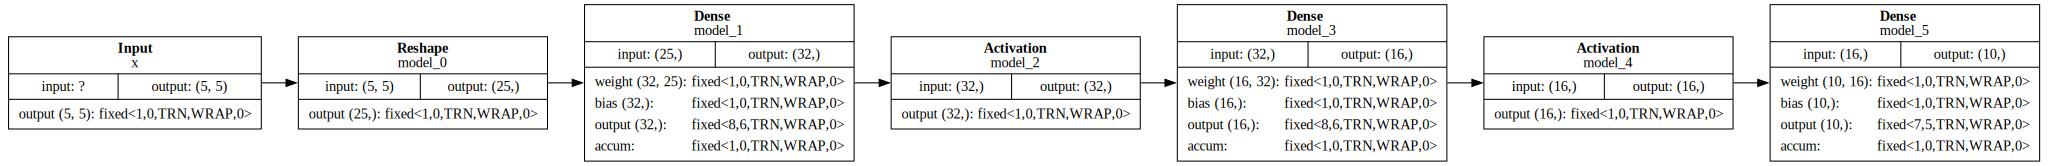

In [11]:
# pip install pydot
# pip install pydotplus
# conda install graphviz

from IPython.display import SVG, display

dot = hls4ml.utils.plot.model_to_dot(
    hls_model,
    show_shapes=True,
    show_precision=True,
    rankdir="LR"
)

out_svg = "hls_model.svg"
dot.write(out_svg, format="svg")
display(SVG(filename=out_svg))



# Building the Model

I first ran the `settings64.bat` in the Vitis_HLS directory and then built the model with:

```bash
vitis_hls -f build_prj.tcl

In [ ]:
# "C:\Xilinx\Vitis_HLS\2024.1\settings64.bat"
# vitis_hls -f build_prj.tcl